In [148]:
import matplotlib.pyplot as plt
import pandas as pd
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
from sqlalchemy import create_engine
import io
import datetime 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

pd.options.display.mpl_style = 'default'


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


## Vehicles
***

In [162]:
string = '''WITH vols as (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
                    WHERE classification_uid in (1,4, 5)
                    AND intersection_uid = 1
                    AND (leg = 'E' AND dir = 'EB')
                    AND extract(dow from datetime_bin) in (1,2,3,4,5)
                GROUP BY datetime_bin
                ORDER BY datetime_bin)

SELECT cast(extract(dow from datetime_bin) as int) as day,  
"time"(datetime_bin) as timestamp, 
avg(volume) as volume
from vols
group by day, timestamp
order by day, timestamp;'''

df = pandasql.read_sql(pg.SQL(string), con)

df

,day,timestamp,volume
0,1,00:00:00,43.5
1,1,00:15:00,40.0
2,1,00:30:00,30.5
3,1,00:45:00,29.5
4,1,01:00:00,27.5
5,1,01:15:00,18.0
6,1,01:30:00,19.5
7,1,01:45:00,19.5
8,1,02:00:00,17.0
9,1,02:15:00,18.0


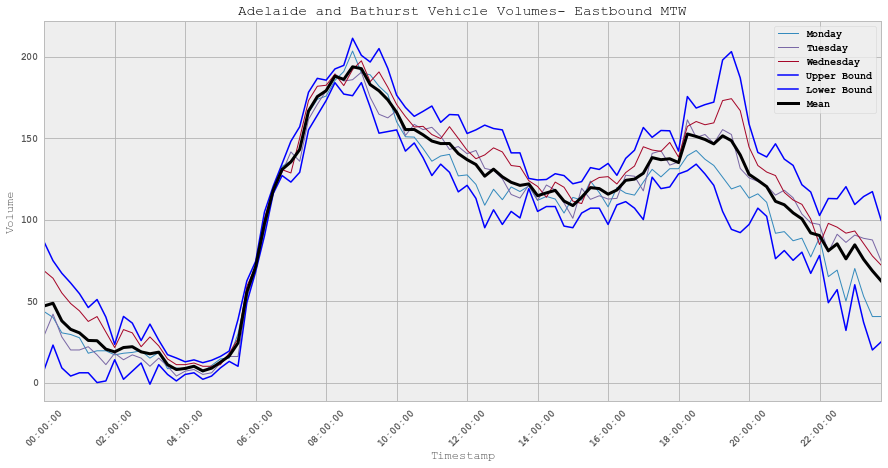

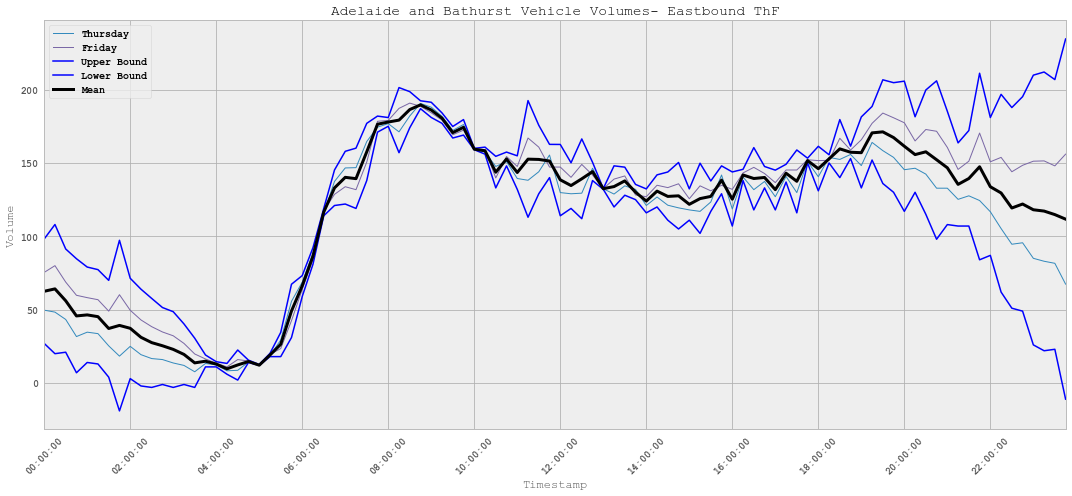

In [150]:
mtw = df.loc[df['day'].isin([1,2,3])]
thf = df.loc[df['day'].isin([4,5])]
mtw.pivot_table(index=['timestamp'], columns=['day'], values=['volume']).plot(rot = 45, figsize = (15, 7))
mean = pd.DataFrame(mtw.groupby('timestamp').mean()).reset_index()
std = pd.DataFrame(mtw.groupby('timestamp').std()).reset_index()
upper = pd.DataFrame(mean['volume'].add(1.96*std['volume']))
upper['timestamp'] = mtw['timestamp']
lower = pd.DataFrame(mean['volume'].add(-1.96*std['volume']).apply(round, 1))
lower['timestamp'] = mtw['timestamp']
times = pd.DataFrame(mean['timestamp'])
plt.plot(times, upper['volume'], linewidth = 1.5, color = 'blue', label = 'Upper Bound')
plt.plot(times, lower['volume'], linewidth = 1.5, color = 'blue', label = 'Lower Bound')
plt.plot(times, mean['volume'], linewidth = 3, color = 'black')
l = plt.legend()
l.get_texts()[0].set_text('Monday')
l.get_texts()[1].set_text('Tuesday')
l.get_texts()[2].set_text('Wednesday')
l.get_texts()[5].set_text('Mean')
labels = [datetime.time(0, 0), datetime.time(2, 0), datetime.time(4, 0),\
          datetime.time(6, 0), datetime.time(8, 0), datetime.time(10, 0),\
          datetime.time(12, 0), datetime.time(14, 0), datetime.time(16, 0),\
          datetime.time(18, 0), datetime.time(20, 0), datetime.time(22, 0)]
plt.title("Adelaide and Bathurst Vehicle Volumes- Eastbound MTW")
plt.xlabel("Timestamp")
plt.xticks(labels)
plt.ylabel("Volume")

thf = df.loc[df['day'].isin([4,5])]
thf.pivot_table(index=['timestamp'], columns=['day'], values=['volume']).plot(rot = 45, figsize = (15, 7))
mean2 = pd.DataFrame(thf.groupby('timestamp').mean()).reset_index()
std2 = pd.DataFrame(thf.groupby('timestamp').std()).reset_index()
upper2 = pd.DataFrame(mean2['volume'].add(1.96*std2['volume']))
upper2['timestamp'] = thf['timestamp']
lower2 = pd.DataFrame(mean2['volume'].add(-1.96*std2['volume']).apply(round, 1))
lower2['timestamp'] = thf['timestamp']
plt.plot(times, upper2['volume'], linewidth = 1.5, color = 'blue', label = 'Upper Bound')
plt.plot(times, lower2['volume'], linewidth = 1.5, color = 'blue', label = 'Lower Bound')
plt.plot(times, mean2['volume'], linewidth = 3, color = 'black')
l = plt.legend()
l.get_texts()[0].set_text('Thursday')
l.get_texts()[1].set_text('Friday')
l.get_texts()[4].set_text('Mean')
labels = [datetime.time(0, 0), datetime.time(2, 0), datetime.time(4, 0),\
          datetime.time(6, 0), datetime.time(8, 0), datetime.time(10, 0),\
          datetime.time(12, 0), datetime.time(14, 0), datetime.time(16, 0),\
          datetime.time(18, 0), datetime.time(20, 0), datetime.time(22, 0)]
plt.title("Adelaide and Bathurst Vehicle Volumes- Eastbound ThF")
plt.xlabel("Timestamp")
plt.xticks(labels)
plt.ylabel("Volume")



plt.tight_layout()
plt.show()

## Bikes 
***

In [151]:
string2 = '''WITH vols as (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
                    WHERE classification_uid in (2, 7)
                    AND intersection_uid = 1
                    AND (leg = 'E' AND dir = 'EB')
                    AND extract(dow from datetime_bin) in (1,2,3,4,5)
                GROUP BY datetime_bin
                ORDER BY datetime_bin)

                SELECT cast(extract(dow from datetime_bin) as int) as day,  
                "time"(datetime_bin) as timestamp, 
                avg(volume) as volume
                from vols
                group by day, timestamp
                order by day, timestamp'''

df2 = pandasql.read_sql(pg.SQL(string2), con)

df2.head(10)

,day,timestamp,volume
0,1,00:00:00,1.0
1,1,00:15:00,1.0
2,1,00:30:00,0.0
3,1,00:45:00,0.5
4,1,01:00:00,0.5
5,1,01:15:00,0.0
6,1,01:30:00,0.0
7,1,01:45:00,0.0
8,1,02:00:00,0.0
9,1,02:15:00,0.0


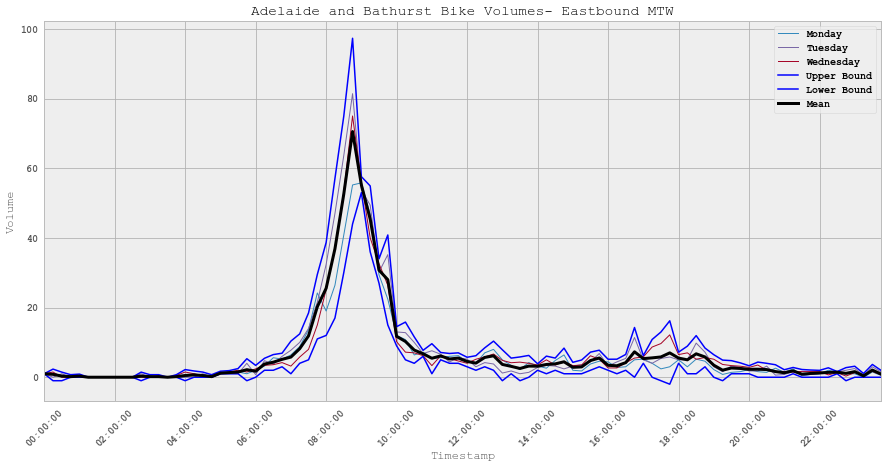

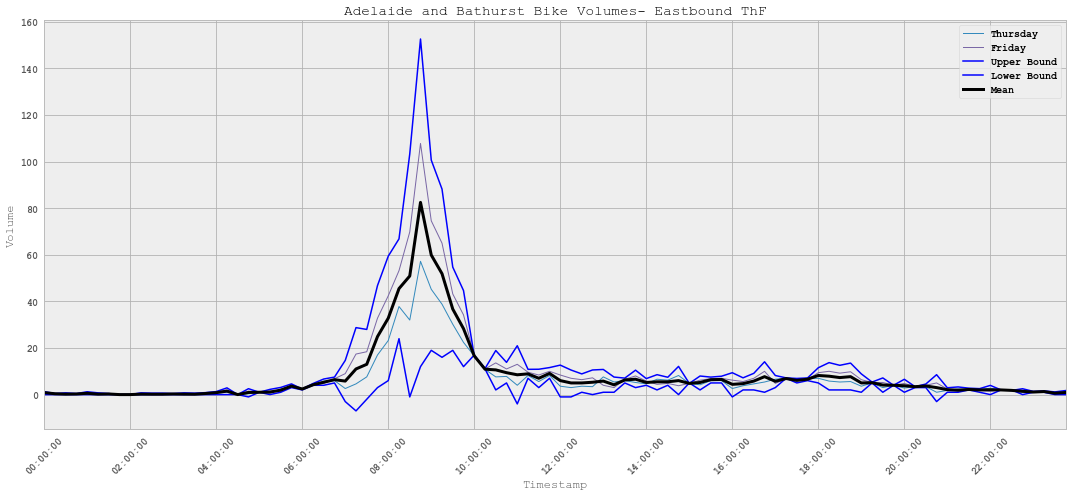

In [152]:
mtw = df2.loc[df2['day'].isin([1,2,3])]
thf = df2.loc[df2['day'].isin([4,5])]
mtw.pivot_table(index=['timestamp'], columns=['day'], values=['volume']).plot(rot = 45, figsize = (15, 7))
mean = pd.DataFrame(mtw.groupby('timestamp').mean()).reset_index()
std = pd.DataFrame(mtw.groupby('timestamp').std()).reset_index()
upper = pd.DataFrame(mean['volume'].add(1.96*std['volume']))
upper['timestamp'] = mtw['timestamp']
lower = pd.DataFrame(mean['volume'].add(-1.96*std['volume']).apply(round, 1))
lower['timestamp'] = mtw['timestamp']
times = pd.DataFrame(mean['timestamp'])
plt.plot(times, upper['volume'], linewidth = 1.5, color = 'blue', label = 'Upper Bound')
plt.plot(times, lower['volume'], linewidth = 1.5, color = 'blue', label = 'Lower Bound')
plt.plot(times, mean['volume'], linewidth = 3, color = 'black')
l = plt.legend()
l.get_texts()[0].set_text('Monday')
l.get_texts()[1].set_text('Tuesday')
l.get_texts()[2].set_text('Wednesday')
l.get_texts()[5].set_text('Mean')
labels = [datetime.time(0, 0), datetime.time(2, 0), datetime.time(4, 0),\
          datetime.time(6, 0), datetime.time(8, 0), datetime.time(10, 0),\
          datetime.time(12, 0), datetime.time(14, 0), datetime.time(16, 0),\
          datetime.time(18, 0), datetime.time(20, 0), datetime.time(22, 0)]
plt.title("Adelaide and Bathurst Bike Volumes- Eastbound MTW")
plt.xlabel("Timestamp")
plt.xticks(labels)
plt.ylabel("Volume")

thf = df2.loc[df2['day'].isin([4,5])]
thf.pivot_table(index=['timestamp'], columns=['day'], values=['volume']).plot(rot = 45, figsize = (15, 7))
mean2 = pd.DataFrame(thf.groupby('timestamp').mean()).reset_index()
std2 = pd.DataFrame(thf.groupby('timestamp').std()).reset_index()
upper2 = pd.DataFrame(mean2['volume'].add(1.96*std2['volume']))
upper2['timestamp'] = thf['timestamp']
lower2 = pd.DataFrame(mean2['volume'].add(-1.96*std2['volume']).apply(round, 1))
lower2['timestamp'] = thf['timestamp']
plt.plot(times, upper2['volume'], linewidth = 1.5, color = 'blue', label = 'Upper Bound')
plt.plot(times, lower2['volume'], linewidth = 1.5, color = 'blue', label = 'Lower Bound')
plt.plot(times, mean2['volume'], linewidth = 3, color = 'black')
l = plt.legend()
l.get_texts()[0].set_text('Thursday')
l.get_texts()[1].set_text('Friday')
l.get_texts()[4].set_text('Mean')
labels = [datetime.time(0, 0), datetime.time(2, 0), datetime.time(4, 0),\
          datetime.time(6, 0), datetime.time(8, 0), datetime.time(10, 0),\
          datetime.time(12, 0), datetime.time(14, 0), datetime.time(16, 0),\
          datetime.time(18, 0), datetime.time(20, 0), datetime.time(22, 0)]
plt.title("Adelaide and Bathurst Bike Volumes- Eastbound ThF")
plt.xlabel("Timestamp")
plt.xticks(labels)
plt.ylabel("Volume")



plt.tight_layout()
plt.show()

## Peds
***

In [153]:
string3 = '''WITH vols as (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
                    WHERE classification_uid = 6
                    AND intersection_uid = 1
                    AND (leg = 'E' AND dir = 'NB')
                    AND extract(dow from datetime_bin) in (1,2,3,4,5)
                GROUP BY datetime_bin
                ORDER BY datetime_bin)

            SELECT cast(extract(dow from datetime_bin) as int) as day,  
            "time"(datetime_bin) as timestamp, 
            avg(volume) as volume
            from vols
            group by day, timestamp
            order by day, timestamp;'''

df3 = pandasql.read_sql(pg.SQL(string3), con)

df3.head(10)

,day,timestamp,volume
0,1,00:00:00,2.0
1,1,00:15:00,4.0
2,1,00:30:00,2.0
3,1,00:45:00,3.0
4,1,01:00:00,1.5
5,1,01:15:00,1.5
6,1,01:30:00,4.0
7,1,01:45:00,1.5
8,1,02:00:00,7.5
9,1,02:15:00,1.5


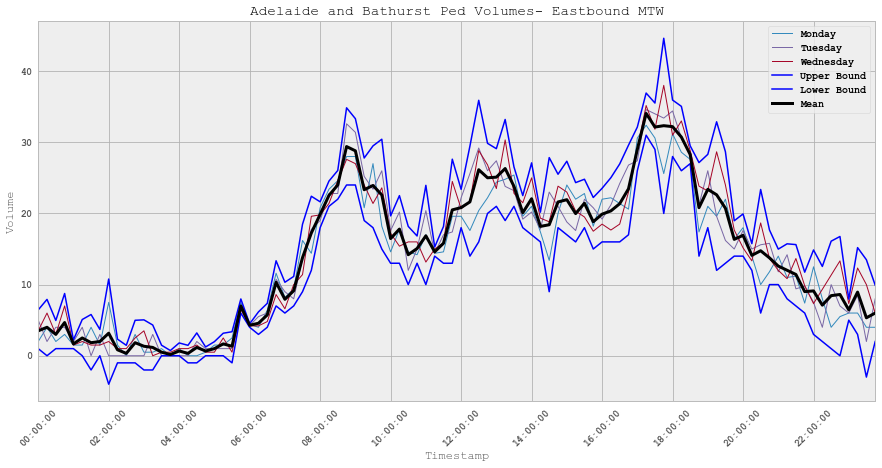

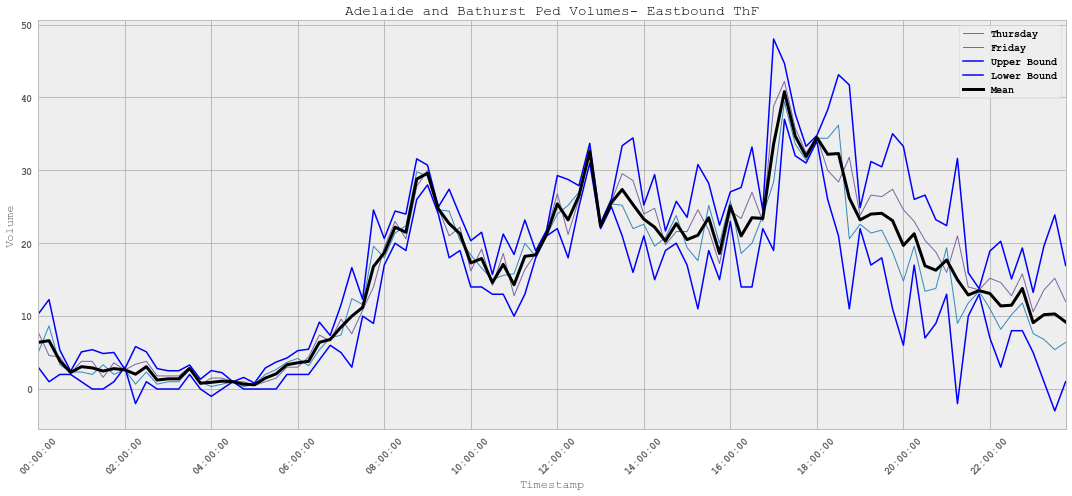

In [154]:
mtw = df3.loc[df3['day'].isin([1,2,3])]
thf = df3.loc[df3['day'].isin([4,5])]
mtw.pivot_table(index=['timestamp'], columns=['day'], values=['volume']).plot(rot = 45, figsize = (15, 7))
mean = pd.DataFrame(mtw.groupby('timestamp').mean()).reset_index()
std = pd.DataFrame(mtw.groupby('timestamp').std()).reset_index()
upper = pd.DataFrame(mean['volume'].add(1.96*std['volume']))
upper['timestamp'] = mtw['timestamp']
lower = pd.DataFrame(mean['volume'].add(-1.96*std['volume']).apply(round, 1))
lower['timestamp'] = mtw['timestamp']
times = pd.DataFrame(mean['timestamp'])
plt.plot(times, upper['volume'], linewidth = 1.5, color = 'blue', label = 'Upper Bound')
plt.plot(times, lower['volume'], linewidth = 1.5, color = 'blue', label = 'Lower Bound')
plt.plot(times, mean['volume'], linewidth = 3, color = 'black')
l = plt.legend()
l.get_texts()[0].set_text('Monday')
l.get_texts()[1].set_text('Tuesday')
l.get_texts()[2].set_text('Wednesday')
l.get_texts()[5].set_text('Mean')
labels = [datetime.time(0, 0), datetime.time(2, 0), datetime.time(4, 0),\
          datetime.time(6, 0), datetime.time(8, 0), datetime.time(10, 0),\
          datetime.time(12, 0), datetime.time(14, 0), datetime.time(16, 0),\
          datetime.time(18, 0), datetime.time(20, 0), datetime.time(22, 0)]
plt.title("Adelaide and Bathurst Ped Volumes- Eastbound MTW")
plt.xlabel("Timestamp")
plt.xticks(labels)
plt.ylabel("Volume")

thf = df3.loc[df3['day'].isin([4,5])]
thf.pivot_table(index=['timestamp'], columns=['day'], values=['volume']).plot(rot = 45, figsize = (15, 7))
mean2 = pd.DataFrame(thf.groupby('timestamp').mean()).reset_index()
std2 = pd.DataFrame(thf.groupby('timestamp').std()).reset_index()
upper2 = pd.DataFrame(mean2['volume'].add(1.96*std2['volume']))
upper2['timestamp'] = thf['timestamp']
lower2 = pd.DataFrame(mean2['volume'].add(-1.96*std2['volume']).apply(round, 1))
lower2['timestamp'] = thf['timestamp']
plt.plot(times, upper2['volume'], linewidth = 1.5, color = 'blue', label = 'Upper Bound')
plt.plot(times, lower2['volume'], linewidth = 1.5, color = 'blue', label = 'Lower Bound')
plt.plot(times, mean2['volume'], linewidth = 3, color = 'black')
l = plt.legend()
l.get_texts()[0].set_text('Thursday')
l.get_texts()[1].set_text('Friday')
l.get_texts()[4].set_text('Mean')
labels = [datetime.time(0, 0), datetime.time(2, 0), datetime.time(4, 0),\
          datetime.time(6, 0), datetime.time(8, 0), datetime.time(10, 0),\
          datetime.time(12, 0), datetime.time(14, 0), datetime.time(16, 0),\
          datetime.time(18, 0), datetime.time(20, 0), datetime.time(22, 0)]
plt.title("Adelaide and Bathurst Ped Volumes- Eastbound ThF")
plt.xlabel("Timestamp")
plt.xticks(labels)
plt.ylabel("Volume")



plt.tight_layout()
plt.show()